<a href="https://colab.research.google.com/github/maragraziani/miccaihackathon_shifts/blob/main/notebooks/GenerateUncertaintyMasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task 1 at the MICCAI Hackathon 2022**
# Domain Shifts Between Clinical Annotators
**written by Vatsal Raina and Nataliia Molchanova, led by Mara Graziani and Henning Müller**
* vr311@cam.ac.uk 
* nataliia.molchanova@hevs.ch
* mara.graziani@hevs.ch ; @mormontre

Under the context of the [Shifts 2.0 project](https://https://shiftsproject.io/).

<figure class="image">
  <img src="https://github.com/maragraziani/miccaihackathon_shifts/blob/main/images/logo.jpeg?raw=true" width="900">
</figure>
The Shifts Project is an international collaboration of academic and industrial researchers dedicated to **studying distributional shift** — one of the biggest challenges in applying machine learning to high-stakes real-world tasks.

The goal of the project is to raise awareness of distributional shift, collect datasets and benchmarks, facilitate cross-disciplinary research, and organize challenges and workshops.

Ideally, machine learning models should generalize well under a range of distributional shifts. If they fail to generalize, these models should indicate this using uncertainty estimates, which enables us to take actions that improve the safety and reliability of the ML system. Techniques that induce invariant or equivariant representations, prevent feature collapse

## Notebook content

1. Motivation for uncertainty estimation
2. Uncertainty estimation basics
3. Uncertainty estimation for white matter multiple sclerosis lesion segmentation task:
    * Data loading
    * Baseline model loading
    * Model inference and uncertainty estimation
    * Saving predictions and uncertainty maps
    * Handling neuroimaging [Nifti](https://nifti.nimh.nih.gov) format


## 1. Motivation

*   Deep Learning models show poor generalization to real world datasets [1], little robustness to adversarial examples [2] and dangerous hidden biases [3]
*   In general, the greater the dataset shift between training and deployment data, the poorer the model performance on the unseen dataset. 
* Evaluating the model in terms of the sole performance on in-domain test data is not sufficient [4] 
* Estimating model uncertainty gives further insights on the model performance and it can lead to more actionable decisions in human-machine pairings.

**References**

[1]Arvidsson, I., Overgaard, N. C., Marginean, F.-E., Krzyzanowska, A., Bjartell, A., ̊Astr ̈om, K. & Heyden, A. (2018), Generalization of prostate cancer classification for multiple sites using deep learning, in ‘2018 IEEE 15th International Symposium on Biomedical Imaging (ISBI 2018)’, IEEE, pp. 191–194. 

[2]Nguyen, Anh, Jason Yosinski, and Jeff Clune. "Deep neural networks are easily fooled: High confidence predictions for unrecognizable images." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.

[3]Zou, James, and Londa Schiebinger. "AI can be sexist and racist—it’s time to make it fair." Nature (2018): 324-326.

[4]Doshi-Velez, Finale, and Been Kim. "Towards a rigorous science of interpretable machine learning." arXiv preprint arXiv:1702.08608 (2017).

[5] Malinin, Andrey et al. “Shifts: A Dataset of Real Distributional Shift Across Multiple Large-Scale Tasks.” *ArXiv abs/2107.07455 (2021)*

[6] Koh, Pang Wei, et al. "Wilds: A benchmark of in-the-wild distribution shifts." International Conference on Machine Learning. PMLR, 2021.

[7] Nair, Tanya, et al. "Exploring uncertainty measures in deep networks for multiple sclerosis lesion detection and segmentation."* Medical image analysis 59 (2020): 101557.*




## 2. Uncertainty Estimation Basics

Consider the following example (credits: TwinEd Productions https://www.youtube.com/watch?v=Osju20L6Z3I)

![picture](https://github.com/maragraziani/InterpretabilityVISUM22/blob/main/images/basics_uncertainty.png?raw=true)

In the first case, the model has high certainty about the prediction. 

In the second case, the distribution on the output classes is quite uniform, and this characterizes a high uncertainty of the model on the predicted class. 

When we have a single model, we can only estimate data uncertainty.

#### A common way to estimate total uncertainty is through model ensembles. 

* Multiple models with identical architectures are trained with different initialization seeds on the same training data and tested on the same image. 
* For N models in the ensemble, we obtain N different softmax outcomes

#### From the ensemble, we can compute multiple uncertainty estimates

**Entropy measures of uncertainty** 

* MEAN Uncertainty = Entropy (expected prediction of ensemble) - measure of total uncertainty
```
def entropy_of_expected(probs):
    [...]
    return np.sum(mean_probs * log_probs, axis=-1)
```
* Expected Entropy = Mean (individual models entropies) - measure of data uncertainty
```
def expected_entropy(probs):
  [...]
  return np.mean(np.sum(probs * log_probs, axis=-1), axis=0)
```

**Mutual Information**
* We can fit a Gaussian distribution on top of the ensemble predictions on the simplex. The variance of the distribution is also indicative of model uncertainty. 
* The Mutual Information (MI) is computed between the probability distributions of each ensemble outcome. 
* Mutual information is computed as the difference between our total uncertainty estimate (entropy of expected) and our measure of data uncertainty (expected entropy) - measure of model uncertainty
```
def mutual_information(eoe, ee):
  [...]
  mutual_info = eoe - exe
  return mutual_info
```


## 3. Demonstration on White Matter Lesion Segmentation for MRI of Multiple Sclerosis 

#### [DEMO] Installation and set up

Start with uploading the data by following these steps:
- Sign DUA and download the data from Zenodo
- Upload the "msseg/eval_in" folder to your google drive
- Mount your google drive to colab notebook (see cell below)

In [1]:
# Mount your google drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Verify that data is accessibe and in the correct directory
# fg_mask  flair	gt  individual_annotators  pd  t1  t1ce  t2
!ls "drive/MyDrive/eval_in"

fg_mask  flair	gt  individual_annotators  pd  t1  t1ce  t2


Download trained baseline models

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1eTTgga7Cd1GjR0YupVbLuLd3unl6_Jj3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1eTTgga7Cd1GjR0YupVbLuLd3unl6_Jj3" -O models.tar.gz && rm -rf /tmp/cookies.txt
!tar -xzvf models.tar.gz

--2022-08-30 09:13:42--  https://docs.google.com/uc?export=download&confirm=t&id=1eTTgga7Cd1GjR0YupVbLuLd3unl6_Jj3
Resolving docs.google.com (docs.google.com)... 142.250.136.138, 142.250.136.113, 142.250.136.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.136.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-b4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3o8mq6gqcefivrikgk750k2f29kjb5hn/1661850750000/17412464615910489214/*/1eTTgga7Cd1GjR0YupVbLuLd3unl6_Jj3?e=download&uuid=8e908820-b261-4efd-afc0-50cd82a0c8b2 [following]
--2022-08-30 09:13:42--  https://doc-14-b4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/3o8mq6gqcefivrikgk750k2f29kjb5hn/1661850750000/17412464615910489214/*/1eTTgga7Cd1GjR0YupVbLuLd3unl6_Jj3?e=download&uuid=8e908820-b261-4efd-afc0-50cd82a0c8b2
Resolving doc-14-b4-docs.googleusercontent.com (doc-14-b4-docs.googleusercontent.com)... 172.217.212.

Install and import requirements

In [4]:
!pip install numpy
!pip install matplotlib
!pip install torch
!pip install monai[all]==0.9.0
!pip install nilearn
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 939 kB 4.8 MB/s 
     |████████████████████████████████| 31.0 MB 65.9 MB/s 
     |████████████████████████████████| 125 kB 71.5 MB/s 
     |████████████████████████████████| 87 kB 8.5 MB/s 
     |████████████████████████████████| 8.6 MB 53.5 MB/s 
     |████████████████████████████████| 17.0 MB 38.2 MB/s 
     |████████████████████████████████| 4.7 MB 48.9 MB/s 
     |████████████████████████████████| 251 kB 63.8 MB/s 
     |████████████████████████████████| 316 kB 66.5 MB/s 
     |████████████████████████████████| 15.0 MB 199 kB/s 
     |███████████████████

In [5]:
# Import libraries
import os
from glob import glob
import re
import numpy as np
import torch
from monai.data import CacheDataset, DataLoader
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNet
from monai.transforms import AddChanneld, Compose, LoadImaged, NormalizeIntensityd, ToTensord
from monai.utils import first, set_determinism
from monai.data import write_nifti

#### [DEMO] Preprocess the data 

In [6]:
# Specity the path to the "eval_in/" directory
eval_in_dir = "drive/MyDrive/eval_in"

# Parse all the FLAIR, ground truth and foreground masks files
flair_dir = os.path.join(eval_in_dir, "flair")
gt_dir = os.path.join(eval_in_dir, "gt")
fg_mask_dir = os.path.join(eval_in_dir, "fg_mask")

flair_files = sorted(glob(os.path.join(flair_dir, "*FLAIR_isovox.nii.gz")),
              key=lambda i: int(re.sub('\D', '', i)))
gt_files = sorted(glob(os.path.join(gt_dir, "*gt_isovox.nii.gz")),
              key=lambda i: int(re.sub('\D', '', i)))
fg_mask = sorted(glob(os.path.join(fg_mask_dir, "*isovox_fg_mask.nii.gz")),
              key=lambda i: int(re.sub('\D', '', i)))

test_files = [{'image': f, "label": s, "fg_mask": m} 
              for f, s, m in zip(flair_files, gt_files, fg_mask)]

print("Testing cases:", len(test_files))
# Define transforms
val_transforms = Compose(
[
    LoadImaged(keys=["image", "label", "fg_mask"]),
    AddChanneld(keys=["image","label"]),
    NormalizeIntensityd(keys=["image"], nonzero=True),
    ToTensord(keys=["image", "label"]),
]
)
# Define dataset and dataloader to iterate the data
val_ds = CacheDataset(data=test_files, transform=val_transforms, 
                      cache_rate=0.1, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)

Testing cases: 24


Loading dataset: 100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


#### [DEMO] Define functions to compute uncertainty measures

In [7]:
"""
Implementation of standard predictive uncertainty measures for image segmentation
"""

def entropy_of_expected(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
    :return: array [num_voxels_X, num_voxels_Y, num_voxels_Z,]
    """
    mean_probs = np.mean(probs, axis=0)
    log_probs = -np.log(mean_probs + epsilon)
    return np.sum(mean_probs * log_probs, axis=-1)

def expected_entropy(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
    :return: array [num_voxels_X, num_voxels_Y, num_voxels_Z,]
    """
    log_probs = -np.log(probs + epsilon)
    return np.mean(np.sum(probs * log_probs, axis=-1), axis=0)


def ensemble_uncertainties_classification(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
    :return: Dictionary of uncertainties
    """
    mean_probs = np.mean(probs, axis=0)
    mean_lprobs = np.mean(np.log(probs + epsilon), axis=0)
    conf = np.max(mean_probs, axis=-1)

    eoe = entropy_of_expected(probs, epsilon)
    exe = expected_entropy(probs, epsilon)

    mutual_info = eoe - exe

    epkl = -np.sum(mean_probs * mean_lprobs, axis=-1) - exe

    uncertainty = {'confidence': -1 * conf,
                   'entropy_of_expected': eoe,
                   'expected_entropy': exe,
                   'mutual_information': mutual_info,
                   'epkl': epkl,
                   'reverse_mutual_information': epkl - mutual_info
                   }

    return uncertainty

#### [DEMO] Run inference, compute estimates over ensemble of 3 models, save predictions and uncertainty maps

---



In [10]:
from IPython.lib.display import exists
import torch
from scipy import ndimage
import re

### HELPER FUCNTIONS ###
def save_outputs(proba_map, fg_mask, bin_seg_map, uncs_dict, affine, 
                 spatial_shape, filename_or_obj, img_prefix='FLAIR_isovox.nii.gz'):
  """ Save models predictions and computed uncertainty maps to Nifti medical imaging format.
  """
  # save probability map
  prob_filename = re.sub(img_prefix, 'pred_prob.nii.gz', filename_or_obj)
  write_nifti(proba_map, 
              os.path.join(save_dir, prob_filename), 
              affine=affine, target_affine=affine,
              output_spatial_shape=spatial_shape)
  # save binary segmentation mask
  prob_filename = re.sub(img_prefix, 'pred_bin.nii.gz', filename_or_obj)
  write_nifti(bin_seg_map, 
              os.path.join(save_dir, prob_filename), 
              affine=affine, target_affine=affine,
              output_spatial_shape=spatial_shape,
              mode='nearest')
  # save all uncertainty
  for uncs_name, uncs_value in uncs_dict.items():
    uncs_filename = re.sub(img_prefix, f'{uncs_name}.nii.gz', filename_or_obj)
    write_nifti(uncs_value * fg_mask, 
                os.path.join(save_dir, uncs_filename), 
                affine=affine, target_affine=affine,
                output_spatial_shape=spatial_shape)

def get_default_device():
    if torch.cuda.is_available():
        print("Got CUDA!")
        return torch.device('cuda')
    else:
        print("Using CPU ;(")
        return torch.device('cpu')

############################

# Threshold to convert probabilistic prediction into binary segmentation mask
th = 0.35
# Number of models in ensemble
K = 3
root_dir = "baselines/"
save_dir = "outputs/"
os.makedirs(save_dir, exist_ok=True)
# Set device
device = get_default_device()
# Initialise models and load weights
models = []
for i in range(K):
    models.append(UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        channels=(32, 64, 128, 256, 512),
        strides=(2, 2, 2, 2),
        num_res_units=0).to(device))
act = torch.nn.Softmax(dim=1)
for i, model in enumerate(models):
    model.load_state_dict(torch.load(os.path.join(root_dir, "seed%d" % (i+1), "Best_model_finetuning.pth"), map_location=device))
    model.eval()
# Evaluation loop
with torch.no_grad():
    for patient_count, batch_data in enumerate(val_loader):
        print("Patient num: ", patient_count)
        inputs, gt, foreground_mask  = \
          batch_data["image"].to(device), \
          batch_data["label"].type(torch.LongTensor).to(device), \
          batch_data["fg_mask"].squeeze(0).numpy()
        roi_size = (96, 96, 96)
        sw_batch_size = 4

        all_outputs = []
        for model in models:
            outputs = sliding_window_inference(inputs, roi_size, sw_batch_size, model, mode='gaussian')
            outputs = act(outputs).cpu().numpy()
            outputs = np.squeeze(outputs[0,1])
            all_outputs.append(outputs)
        all_outputs = np.asarray(all_outputs)
        outputs = np.mean(all_outputs, axis=0)

        # Get all uncertainties
        uncs = ensemble_uncertainties_classification( np.concatenate( (np.expand_dims(all_outputs, axis=-1), np.expand_dims(1.-all_outputs, axis=-1)), axis=-1) )
        
        # Apply threshold to the probability predictions
        seg = outputs.copy()
        seg[seg>=th]=1.0
        seg[seg<th]=0.0
        seg = np.squeeze(seg)

        val_labels = gt.cpu().numpy()
        gt = np.squeeze(val_labels)

        # Remove connected components smaller than 10 voxels
        l_min = 9
        seg_clean = np.zeros_like(seg, dtype=int)
        labeled_seg, num_labels = ndimage.label(seg)
        for label in range(1, num_labels + 1):
          if (labeled_seg == label).sum() > l_min:
            seg_clean += (labeled_seg == label).astype('int')
        seg = seg_clean.copy()

        # Get the Dice score
        if np.sum(seg) + np.sum(gt) == 0:
            value = 1.0
            dsc = value
        else:
            value = (np.sum(seg[gt==1])*2.0) / (np.sum(seg) + np.sum(gt))
            dsc = value.sum().item()
        print("Dice score:", dsc)

        # Save predictions and uncertainty maps to neuroimaging Nifti format (for more info https://nifti.nimh.nih.gov)
        save_outputs(proba_map=np.squeeze(outputs), bin_seg_map=seg, uncs_dict=uncs,
                     fg_mask=foreground_mask,
                     affine=batch_data['image_meta_dict']['original_affine'][0], 
                     spatial_shape=batch_data['image_meta_dict']['spatial_shape'][0], 
                     filename_or_obj=os.path.basename(batch_data['image_meta_dict']['filename_or_obj'][0]))

        # We only look at the results for the first patient
        break

Got CUDA!
Patient num:  0
Dice score: 0.6794881920859331


Predicted probability and binary segmentation maps for **one** subject as well as uncertainty maps for different measures of uncertainty were saved to the "outputs/" folder

In [12]:
!ls outputs

1_confidence.nii.gz	      1_mutual_information.nii.gz
1_entropy_of_expected.nii.gz  1_pred_bin.nii.gz
1_epkl.nii.gz		      1_pred_prob.nii.gz
1_expected_entropy.nii.gz     1_reverse_mutual_information.nii.gz


#### [DEMO] Visualise predictions and uncertainty maps

Loading Nifti (.nii / .nii.gz) images using [nibabel](https://nipy.org/nibabel/gettingstarted.html) library.

In [13]:
import nibabel as nib
# Define subject identifying number
sub_num = 1
# Define an uncertainty measure to be loaded
unc_measure = "entropy_of_expected"
# Load Nifti (.nii.gz) images using nibabel library: nibabel.load(filename)
flair, gt_bin_seg, pred_bin_seg, uncs_map = \
  nib.load(os.path.join(flair_dir, f"{sub_num}_FLAIR_isovox.nii.gz")), \
  nib.load(os.path.join(gt_dir, f"{sub_num}_gt_isovox.nii.gz")), \
  nib.load(os.path.join(save_dir, f"{sub_num}_pred_bin.nii.gz")), \
  nib.load(os.path.join(save_dir, f"{sub_num}_{unc_measure}.nii.gz"))
# If you want to convert loaded nibabel.Nifti1Image() instances to 3D numpy arrays 
# use nibabel.Nifti1Image.get_fdata(), example: flair_numpy = flair.get_fdata()

Visualise loaded images using [nilearn](https://nilearn.github.io/stable/) library.

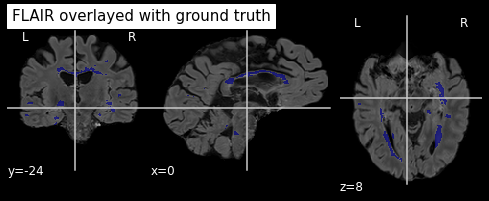

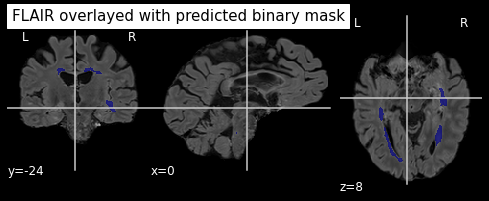

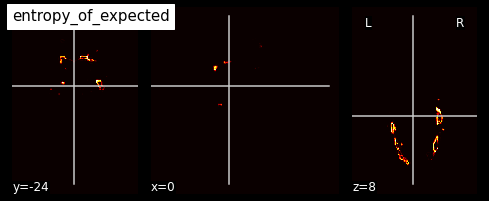

In [16]:
from nilearn.plotting import plot_img, plot_roi, show

cut_coords = (0, -24, 8)
# 1. Visualising slices of 3D Nifti images with an overlay: nilearn.plotting.plot_roi
# FLAIR overlayed with ground truth
plot_roi(roi_img=gt_bin_seg, bg_img=flair, cut_coords=cut_coords, black_bg=True, 
         title='FLAIR overlayed with ground truth')
show()
# FLAIR overlayed with predicted binary mask
plot_roi(roi_img=pred_bin_seg, bg_img=flair, cut_coords=cut_coords, black_bg=True, 
         title='FLAIR overlayed with predicted binary mask')
show()
# 2. Visualise slices of 3D Nifti images
# Uncertainty map
plot_img(img=uncs_map, cut_coords=cut_coords, title=unc_measure, cmap='hot', black_bg=True)
show()